In [1]:
#Install GO package
!pip install goatools

  Using cached goatools-1.4.12-py3-none-any.whl.metadata (14 kB)
  Using cached docopt-0.6.2-py2.py3-none-any.whl
  Using cached ftpretty-0.4.0-py2.py3-none-any.whl.metadata (6.6 kB)
  Using cached pydot-3.0.2-py3-none-any.whl.metadata (10 kB)
Using cached goatools-1.4.12-py3-none-any.whl (15.8 MB)
Using cached ftpretty-0.4.0-py2.py3-none-any.whl (8.2 kB)
Using cached pydot-3.0.2-py3-none-any.whl (35 kB)


In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import goatools 
import matplotlib.patches as mpatches
import statsmodels.api as sm
from goatools.associations import read_gaf
from sklearn.cluster import KMeans
np.set_printoptions(precision=5, suppress=True)  # suppress scientific floatation 
sns.set(color_codes=True)
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [3]:
# Read the GAF file 
gaf_file = "goa_yeast.gaf"
columns = [
    "DB", "DB_Object_ID", "DB_Object_Symbol", "Qualifier", "GO_ID", "DB_Reference",
    "Evidence_Code", "With_From", "Aspect", "DB_Object_Name", "DB_Object_Synonym",
    "DB_Object_Type", "Taxon", "Date", "Assigned_By", "Annotation_Extension", "Gene_Product_Form_ID"
]

# Read the GAF file into a pandas DataFrame (skipping commented lines)
gaf_df = pd.read_csv(gaf_file, sep="\t", comment="!", names=columns)
gaf_df

,DB,DB_Object_ID,DB_Object_Symbol,Qualifier,GO_ID,DB_Reference,Evidence_Code,With_From,Aspect,DB_Object_Name,DB_Object_Synonym,DB_Object_Type,Taxon,Date,Assigned_By,Annotation_Extension,Gene_Product_Form_ID
0,UniProtKB,A0A023PYF4,YER145C-A,enables,GO:0003674,GO_REF:0000015,ND,NaN,F,Uncharacterized protein YER145C-A,YER145C-A,protein,taxon:559292,20150720,SGD,NaN,NaN
1,UniProtKB,A0A023PYF4,YER145C-A,enables,GO:0003674,GO_REF:0000015,ND,NaN,F,Uncharacterized protein YER145C-A,YER145C-A,protein,taxon:559292,20150720,SGD,part_of(GO:0008150),NaN
2,UniProtKB,A0A023PYF4,YER145C-A,involved_in,GO:0008150,GO_REF:0000015,ND,NaN,P,Uncharacterized protein YER145C-A,YER145C-A,protein,taxon:559292,20150720,SGD,NaN,NaN
3,UniProtKB,A0A023PYF4,YER145C-A,is_active_in,GO:0005575,GO_REF:0000015,ND,NaN,C,Uncharacterized protein YER145C-A,YER145C-A,protein,taxon:559292,20150720,SGD,NaN,NaN
4,UniProtKB,A0A023PZB3,FMP49,enables,GO:0003674,GO_REF:0000015,ND,NaN,F,"Protein FMP49, mitochondrial",FMP49|YER038W-A,protein,taxon:559292,20150720,SGD,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110708,UniProtKB,Q9ZZX9,Q0010,enables,GO:0003674,GO_REF:0000015,ND,NaN,F,"Putative uncharacterized protein Q0010, mitoch...",Q0010|ORF6,protein,taxon:559292,20130808,SGD,NaN,NaN
110709,UniProtKB,Q9ZZX9,Q0010,enables,GO:0003674,GO_REF:0000015,ND,NaN,F,"Putative uncharacterized protein Q0010, mitoch...",Q0010|ORF6,protein,taxon:559292,20130808,SGD,part_of(GO:0008150),NaN
110710,UniProtKB,Q9ZZX9,Q0010,involved_in,GO:0008150,GO_REF:0000015,ND,NaN,P,"Putative uncharacterized protein Q0010, mitoch...",Q0010|ORF6,protein,taxon:559292,20130808,SGD,NaN,NaN
110711,UniProtKB,Q9ZZX9,Q0010,is_active_in,GO:0005575,GO_REF:0000015,ND,NaN,C,"Putative uncharacterized protein Q0010, mitoch...",Q0010|ORF6,protein,taxon:559292,20210730,SGD,NaN,NaN


In [4]:
df = pd.read_table("GSE80474_Scerevisiae_normalized.txt")
df = df.rename(columns = {'time_points':'gene'})

# Filtering the data

In [5]:
df_given = df.melt(id_vars = "gene", var_name = "time_point", value_name = "FPKM1")
df_given["time_point"] = pd.to_numeric(df_given["time_point"], downcast="integer")
df_given.head()

,gene,time_point,FPKM1
0,15S_rRNA,0,1.000
1,21S_rRNA,0,1.000
2,HRA1,0,1.853
3,ICR1,0,6.440
4,LSR1,0,16.821


In [6]:
filtered_df = gaf_df.merge(df_given, left_on = 'DB_Object_Symbol', right_on = 'gene')
filtered_df = filtered_df.loc[:, ['GO_ID', 'gene', 'time_point', 'FPKM1' ]]
filtered_df

,GO_ID,gene,time_point,FPKM1
0,GO:0003674,YER145C-A,0,1.656
1,GO:0003674,YER145C-A,5,1.255
2,GO:0003674,YER145C-A,10,1.546
3,GO:0003674,YER145C-A,15,1.293
4,GO:0003674,YER145C-A,20,1.306
...,...,...,...,...
5365995,GO:0005739,Q0010,225,1.000
5365996,GO:0005739,Q0010,230,1.000
5365997,GO:0005739,Q0010,235,1.000
5365998,GO:0005739,Q0010,240,1.000


In [7]:
pseudocount = 1e-6
filtered_df.loc[:, "Log2_FPKM"] = np.log2(filtered_df["FPKM1"] + pseudocount)

In [8]:
filtered_df.loc[:,"Mean_Log2_FPKM"] = filtered_df.groupby("gene")["Log2_FPKM"].transform("mean")

In [9]:
filtered_df.loc[:,"Log2_Fold_Change"] = filtered_df["Log2_FPKM"] - filtered_df["Mean_Log2_FPKM"]
filtered_df = filtered_df.loc[filtered_df["Log2_Fold_Change"] != 0]

In [10]:
filtered_df

,GO_ID,gene,time_point,FPKM1,Log2_FPKM,Mean_Log2_FPKM,Log2_Fold_Change
0,GO:0003674,YER145C-A,0,1.656,0.727704,0.442157,0.285547
1,GO:0003674,YER145C-A,5,1.255,0.327689,0.442157,-0.114468
2,GO:0003674,YER145C-A,10,1.546,0.628541,0.442157,0.186384
3,GO:0003674,YER145C-A,15,1.293,0.370723,0.442157,-0.071434
4,GO:0003674,YER145C-A,20,1.306,0.385156,0.442157,-0.057001
...,...,...,...,...,...,...,...
5362545,GO:0016586,HTL1,225,656.334,9.358286,9.311523,0.046763
5362546,GO:0016586,HTL1,230,588.798,9.201629,9.311523,-0.109894
5362547,GO:0016586,HTL1,235,683.105,9.415964,9.311523,0.104440
5362548,GO:0016586,HTL1,240,642.069,9.326585,9.311523,0.015061


#  Identification of Cell Cycle Stages Based on Gene Markers

In [11]:
selected = ["gene", "time_point", "Log2_Fold_Change"]
filtered_df_markers = filtered_df[selected]
filtered_df_markers = filtered_df_markers.drop_duplicates(subset=["gene", "time_point"])

In [12]:
filtered_df_pivoted = filtered_df_markers.pivot(index='gene', columns='time_point', values='Log2_Fold_Change')

In [13]:
#select marker genes to identify cell cycle phase
markers = {
    "G1": [ 'SIC1', 'CDC28','CDC45', 'CLN2'],
    "S": ['TUB2', 'STU2', 'CLB4'],
    "G2": ['FKH1','BUD3','TUB3', 'CDC14', 'CLB2', 'SWI5'],
    "M": ['CLB1','CDC20', 'CLN3']
}

In [14]:
marker_log2_fc = filtered_df_pivoted.loc[sum(markers.values(), [])]

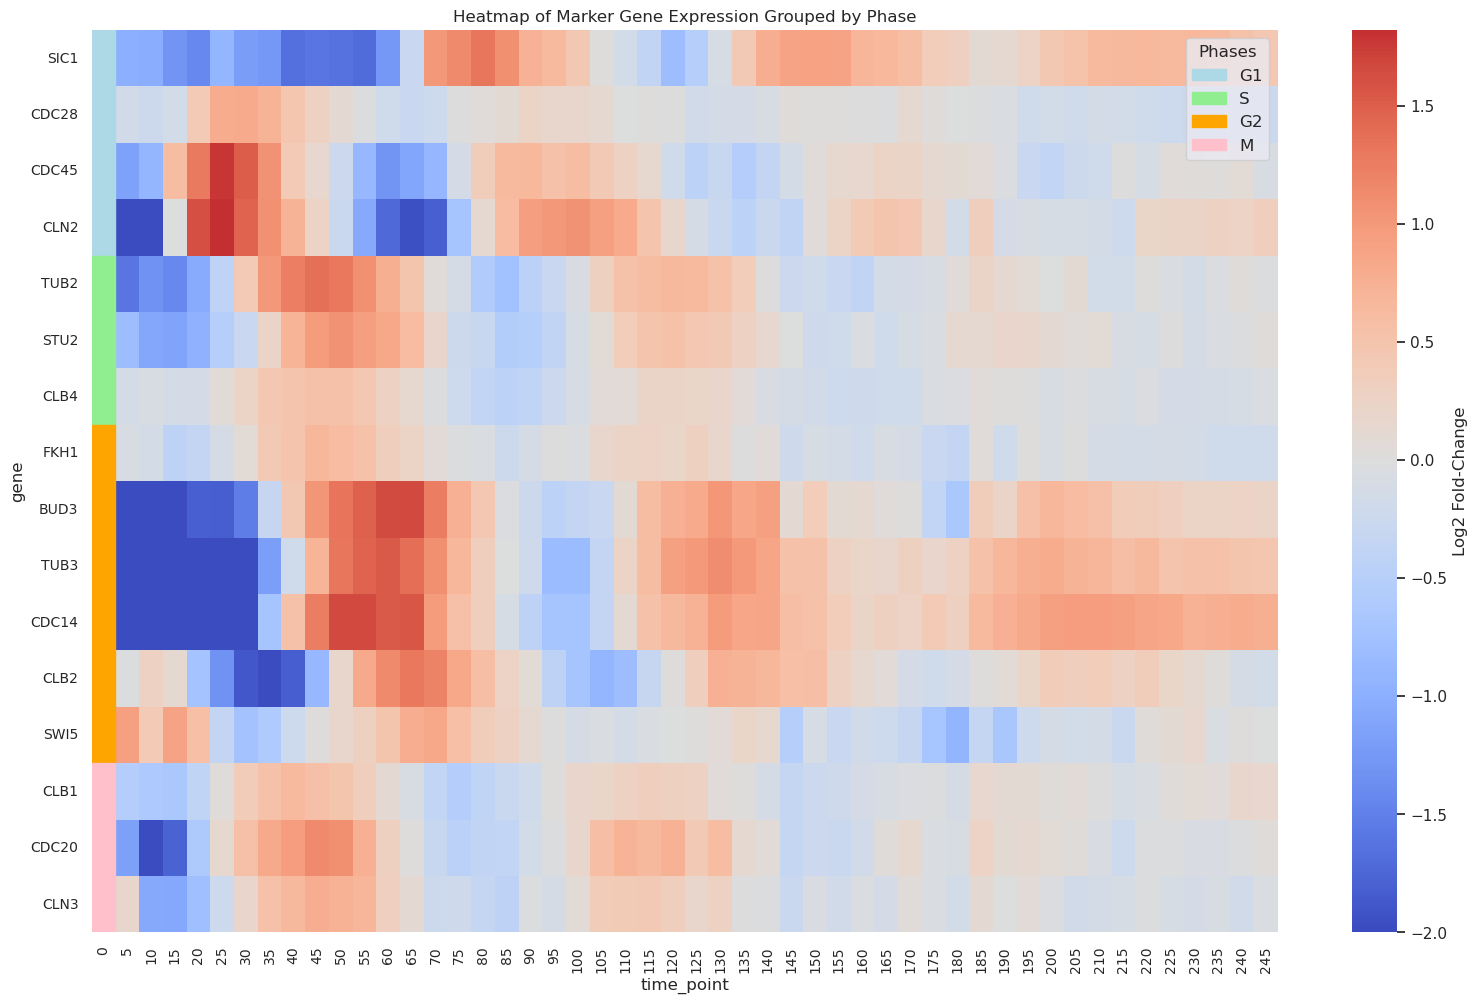

In [15]:
# Flatten the markers dictionary into a list of tuples (gene, phase)
ordered_genes = [(gene, phase) for phase, genes in markers.items() for gene in genes]

# Create a DataFrame with phase information
ordered_gene_list = [gene for gene, _ in ordered_genes]
phases = [phase for _, phase in ordered_genes]

# Create a color map for the phases
phase_colors = {
    "G1": "lightblue",
    "S": "lightgreen",
    "G2": "orange",
    "M": "pink"
}

# Subset the data and reorder by phase
marker_expression = filtered_df_pivoted.loc[ordered_gene_list]
marker_expression['Phase'] = phases
marker_expression = marker_expression.sort_values(by='Phase').drop(columns=['Phase'])

# Create a color list for the phases that corresponds to the sorted data
row_colors = [phase_colors[phase] for phase in phases]

# Plot the heatmap
plt.figure(figsize=(16, 10))

# Create the heatmap
sns.heatmap(
    marker_expression, 
    cmap="coolwarm", 
    xticklabels=True, 
    center = 0,    
    cbar_kws={'label': 'Log2 Fold-Change'}, 
    vmin=-2,
    yticklabels=ordered_gene_list  # Ensure this matches the sorted gene list
)

# Add row colors manually by plotting colored bars
for i, color in enumerate(row_colors):
    plt.gca().add_patch(plt.Rectangle((0, i), 1, 1, color=color)) 

# Create a legend for the phases
legend_patches = [mpatches.Patch(color=color, label=phase) for phase, color in phase_colors.items()]
plt.legend(handles=legend_patches, loc="upper right", title="Phases", fontsize=12)

# Adjust font size for better readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Adjust layout to prevent clipping of labels
plt.tight_layout()
plt.title("Heatmap of Marker Gene Expression Grouped by Phase")
plt.show()


# Analysing the expression patterns of spindle-associated genes throughout the cell cycle.

In [16]:
#extract data from Go tems associated with spindle and cluster to identify patterns across time 
filtered_spindle = filtered_df[filtered_df['GO_ID'].isin(['GO:0007052', 'GO:0051225', 'GO:0000070', 'GO:0000910'])]
filtered_spindle = filtered_spindle.drop_duplicates(subset=["gene", "time_point"])
spindle_filtered_pivot = filtered_spindle.pivot(index="gene", columns="time_point", values="Log2_Fold_Change")

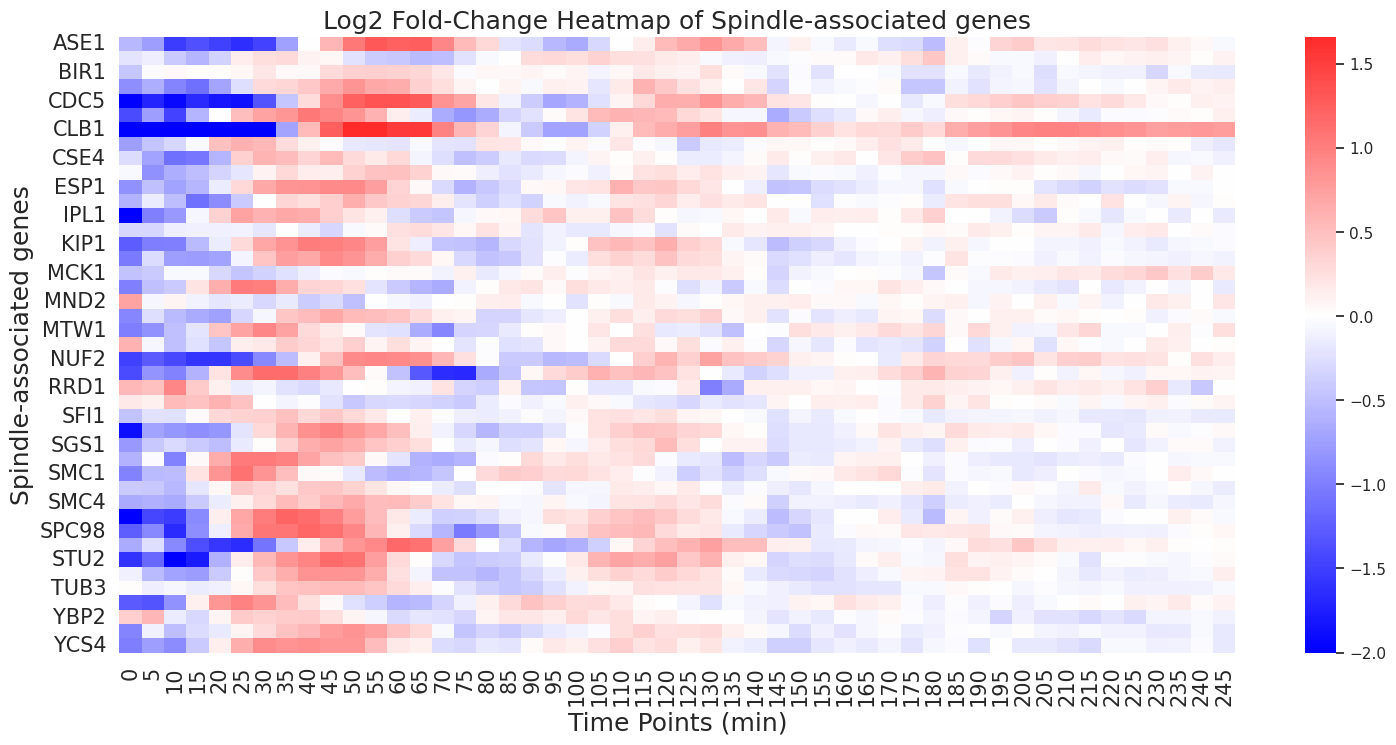

In [17]:
plt.figure(figsize=(18, 8)) 
sns.heatmap(spindle_filtered_pivot, cmap="bwr" , vmin = -2, center=0)
plt.title("Log2 Fold-Change Heatmap of Spindle-associated genes", fontsize = 18)
plt.xlabel("Time Points (min)", fontsize = 18)
plt.ylabel("Spindle-associated genes", fontsize = 18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

# Co-expression

GO:0003779 - Microtubule-based movement: Describes the movement driven by microtubules, including the mitotic spindle

In [18]:
MM = filtered_df[filtered_df['GO_ID'].isin(['GO:0003779'])]

In [19]:
#extract data from Go tems associated with spindle and cluster to identify patterns across time 
filtered_MM_spindle = pd.concat([filtered_spindle, MM], axis=0 )
filtered_MM_spindle = filtered_MM_spindle.drop_duplicates(subset=["gene", "time_point"])
MM_spindle_pivot = filtered_MM_spindle.pivot(index="gene", columns="time_point", values="Log2_Fold_Change")

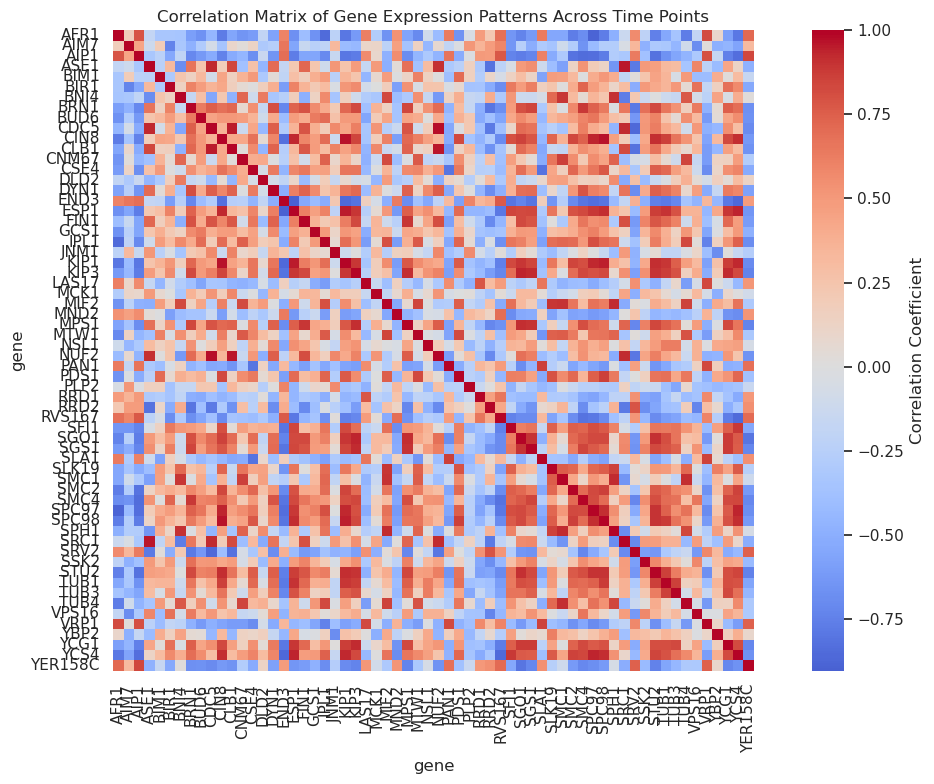

In [20]:
expression_data = MM_spindle_pivot.transpose()  # Transpose if necessary
# Calculate the correlation matrix between the genes' expression patterns over time
correlation_matrix = expression_data.corr(method='pearson')  # You can use 'spearman' if needed

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix, 
    cmap='coolwarm', # Annotate each cell with correlation values
    fmt='.2f',  # Format correlation values
    cbar_kws={'label': 'Correlation Coefficient'},  # Label for color bar
    square=True,  # Make the heatmap square-shaped
    xticklabels= MM_spindle_pivot.index,  # Label columns (genes)
    yticklabels= MM_spindle_pivot.index,  # Label rows (genes)
    center = 0
)

# Add title and adjust layout
plt.title("Correlation Matrix of Gene Expression Patterns Across Time Points")
plt.tight_layout()
plt.show()

Mitotic Sister Chromatid Segregation 

In [21]:
chromatid_segregation  = filtered_df[filtered_df['GO_ID'].isin(['GO:0000070'])]
chromatid_segregation = chromatid_segregation.drop_duplicates(subset=["gene", "time_point"])
chromatid_segregation_pivot = chromatid_segregation.pivot(index="gene", columns="time_point", values="Log2_Fold_Change")

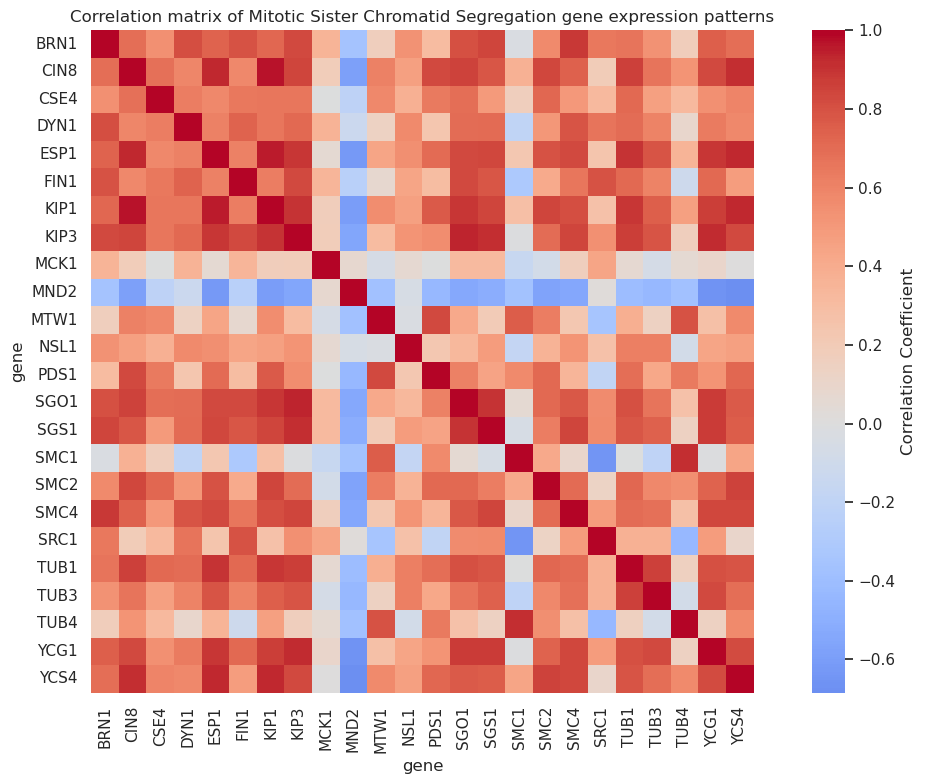

In [22]:
expression_data = chromatid_segregation_pivot.transpose()  # Transpose if necessary
# Calculate the correlation matrix between the genes' expression patterns over time
correlation_matrix = expression_data.corr(method='pearson')  # You can use 'spearman' if needed

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix, 
    cmap='coolwarm', # Annotate each cell with correlation values
    fmt='.2f',  # Format correlation values
    cbar_kws={'label': 'Correlation Coefficient'},  # Label for color bar
    square=True,  # Make the heatmap square-shaped
    xticklabels= chromatid_segregation_pivot.index,  # Label columns (genes)
    yticklabels= chromatid_segregation_pivot.index,  # Label rows (genes)
    center = 0
)

# Add title and adjust layout
plt.title("Correlation matrix of Mitotic Sister Chromatid Segregation gene expression patterns")
plt.tight_layout()
plt.savefig('spindle.png')
plt.show()

<Axes: xlabel='time_point', ylabel='Log2_Fold_Change'>

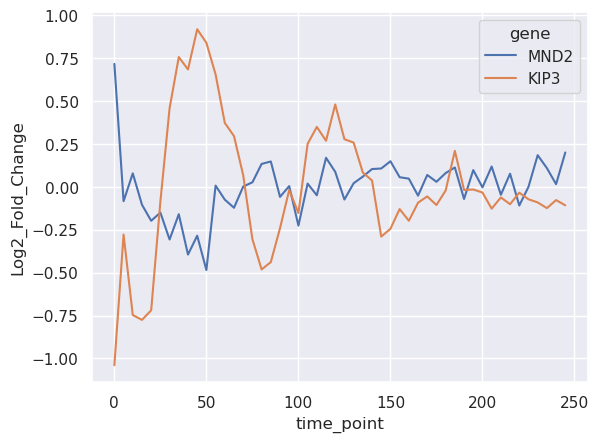

In [23]:
sns.lineplot(data = chromatid_segregation[chromatid_segregation['gene'].isin(['MND2', 'KIP3'])], x="time_point", y="Log2_Fold_Change", hue = "gene")

Correlation matrix of gene expression patterns related to kinetochore assembly and spindle assembly

In [24]:
spindle_assembly = filtered_df[filtered_df['GO_ID'].isin(['GO:0051225'])]
spindle_assembly = spindle_assembly.drop_duplicates(subset=["gene", "time_point"])
spindle_assembly_pivot = spindle_assembly.pivot(index="gene", columns="time_point", values="Log2_Fold_Change")

In [25]:
Kin_assembly = filtered_df[filtered_df['GO_ID'].isin(['GO:0051382'])]
Kin_assembly = Kin_assembly.drop_duplicates(subset=["gene", "time_point"])
Kin_assembly_pivot = Kin_assembly.pivot(index="gene", columns="time_point", values="Log2_Fold_Change")

In [26]:
#extract data from Go tems associated with spindle and cluster to identify patterns across time 
filtered_assebly = pd.concat([Kin_assembly, spindle_assembly], axis=0)
filtered_assebly = filtered_assebly.drop_duplicates(subset=["gene", "time_point"])
filtered_assebly_pivot = filtered_assebly.pivot(index="gene", columns="time_point", values="Log2_Fold_Change")

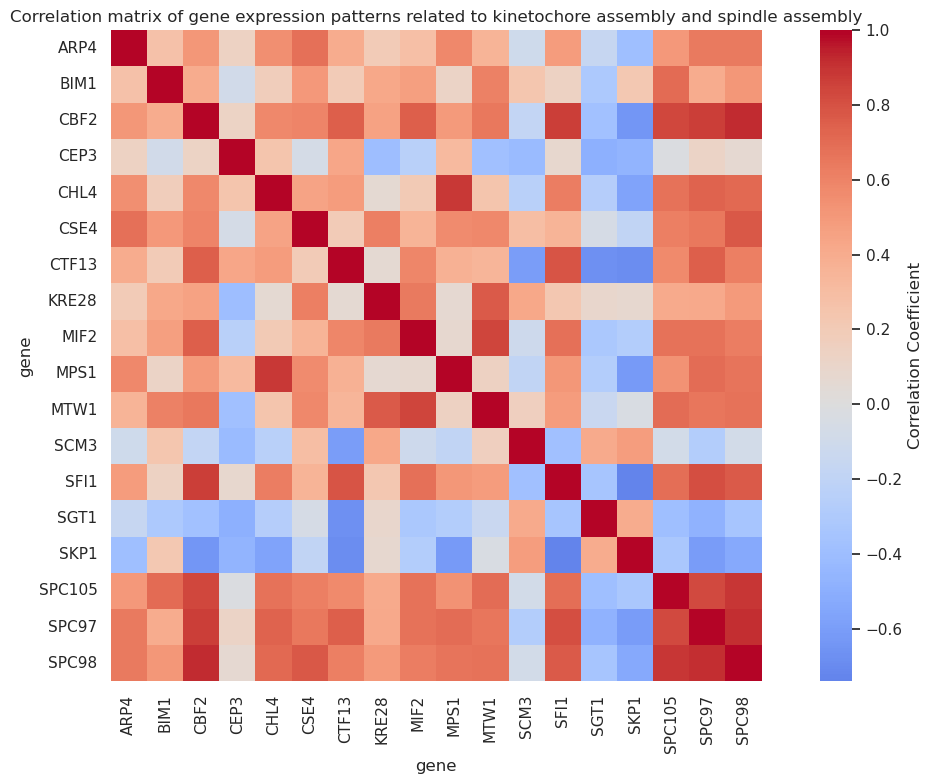

In [27]:
expression_data = filtered_assebly_pivot.transpose()  # Transpose if necessary
# Calculate the correlation matrix between the genes' expression patterns over time
correlation_matrix = expression_data.corr(method='pearson')  # You can use 'spearman' if needed

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix, 
    cmap='coolwarm', # Annotate each cell with correlation values
    fmt='.2f',  # Format correlation values
    cbar_kws={'label': 'Correlation Coefficient'},  # Label for color bar
    square=True,  # Make the heatmap square-shaped
    xticklabels= filtered_assebly_pivot.index,  # Label columns (genes)
    yticklabels= filtered_assebly_pivot.index,  # Label rows (genes)
    center = 0
)

# Add title and adjust layout
plt.title("Correlation matrix of gene expression patterns related to kinetochore assembly and spindle assembly")
plt.tight_layout()
plt.savefig('spindle.png')
plt.show()

<Axes: xlabel='time_point', ylabel='Log2_Fold_Change'>

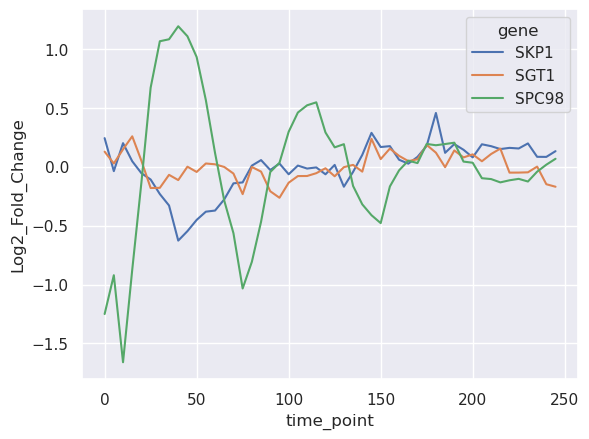

In [28]:
sns.lineplot(data = filtered_assebly[filtered_assebly['gene'].isin(['SKP1', 'SGT1', 'SPC98'])], x="time_point", y="Log2_Fold_Change", hue = "gene")

Mitotic Spindle Organization

In [29]:
s_org  = filtered_df[filtered_df['GO_ID'].isin(['GO:0007052'])]
s_org= s_org.drop_duplicates(subset=["gene", "time_point"])
s_org_pivot = s_org.pivot(index="gene", columns="time_point", values="Log2_Fold_Change")

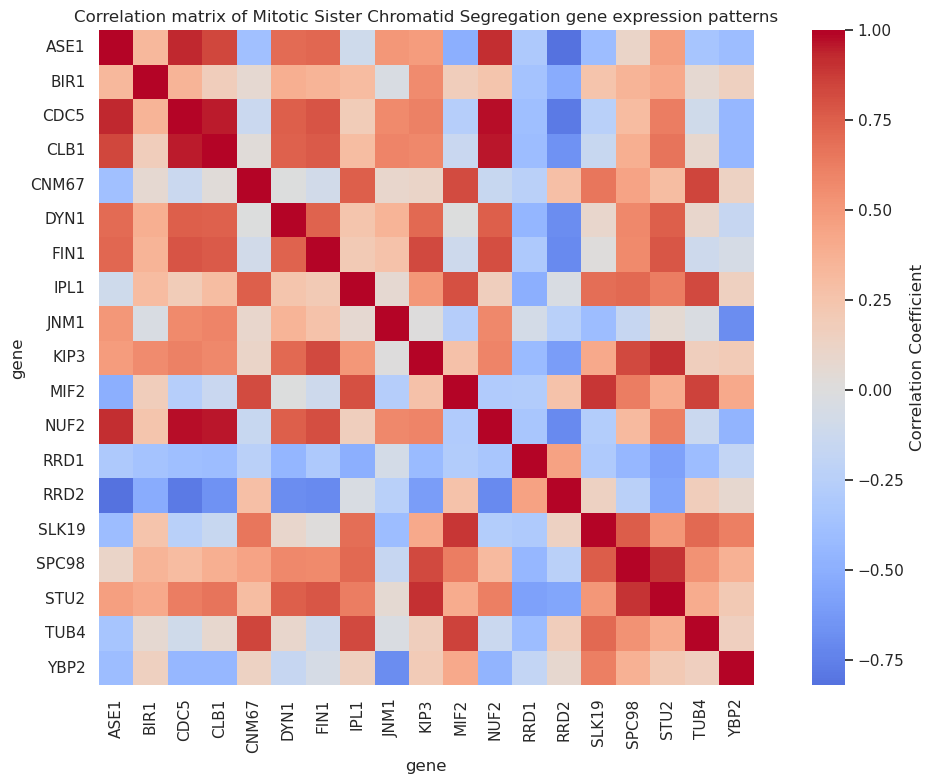

In [30]:
expression_data =  s_org_pivot.transpose()  # Transpose if necessary
# Calculate the correlation matrix between the genes' expression patterns over time
correlation_matrix = expression_data.corr(method='pearson')  # You can use 'spearman' if needed

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix, 
    cmap='coolwarm', # Annotate each cell with correlation values
    fmt='.2f',  # Format correlation values
    cbar_kws={'label': 'Correlation Coefficient'},  # Label for color bar
    square=True,  # Make the heatmap square-shaped
    xticklabels= s_org_pivot.index,  # Label columns (genes)
    yticklabels= s_org_pivot.index,  # Label rows (genes)
    center = 0
)

# Add title and adjust layout
plt.title("Correlation matrix of Mitotic Sister Chromatid Segregation gene expression patterns")
plt.tight_layout()
plt.savefig('spindle.png')
plt.show()

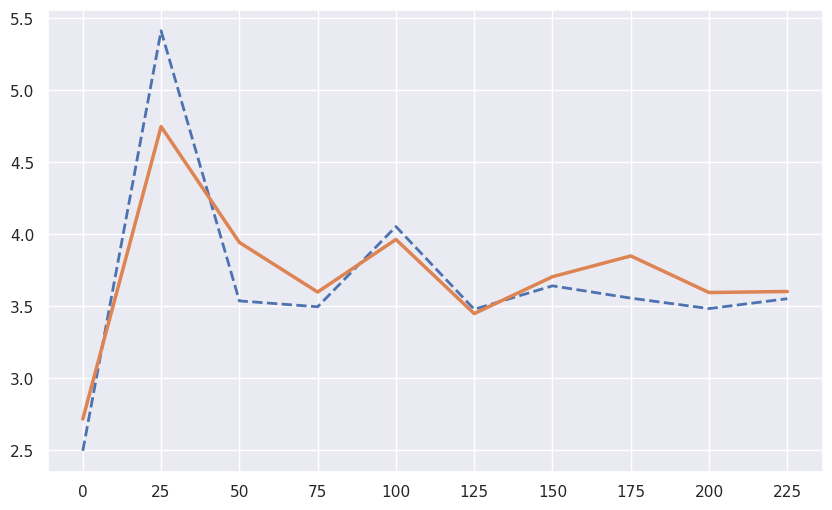

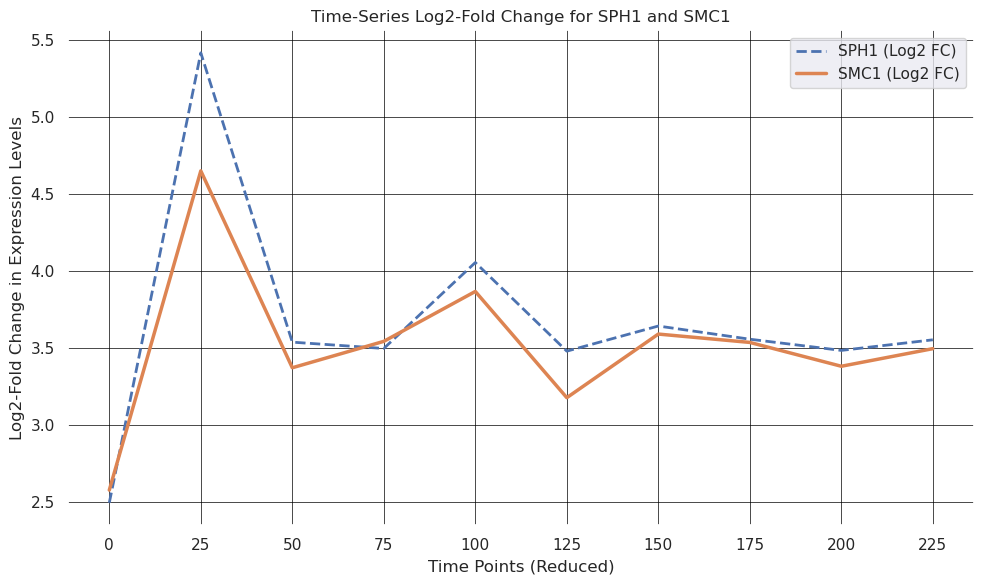

In [35]:
# Load the datasets
expression_file = 'GSE80474_Scerevisiae_normalized.txt'

# Load expression data
expression_data = pd.read_csv(expression_file, sep='\t', index_col=0)

# Specified gene pairs
gene_pairs = [
    ("SPH1", "MIF2"),
    ("SPH1", "SMC1"),
]

# Ensure genes are in the data
available_genes = expression_data.index
valid_pairs = [(g1, g2) for g1, g2 in gene_pairs if g1 in available_genes and g2 in available_genes]

# Compute the log2-fold change for expression levels
log2_expression = np.log2(expression_data.replace(0, np.nan))  # Replace 0 with NaN to avoid log2(0)

# Reduce the number of time points for clearer visualization (e.g., every 5th time point)
reduced_log2_expression = log2_expression.iloc[:, ::5]  # Select every 5th column

# Create individual line plots for each gene pair using the reduced set of time points
for gene1, gene2 in valid_pairs:
    plt.figure(figsize=(10, 6))
    plt.plot(
        reduced_log2_expression.columns, 
        reduced_log2_expression.loc[gene1], 
        label=f"{gene1} (Log2 FC)", 
        linestyle='--',
        linewidth=2
    )
    plt.plot(
        reduced_log2_expression.columns, 
        reduced_log2_expression.loc[gene2], 
        label=f"{gene2} (Log2 FC)", 
        linestyle='-',
        linewidth=2.5
    )
plt.title(f"Time-Series Log2-Fold Change for {gene1} and {gene2}")
plt.xlabel("Time Points (Reduced)")
plt.ylabel("Log2-Fold Change in Expression Levels")
plt.legend()
plt.gca().set_facecolor('white') 
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()